In [1]:
using Pkg
using LinearAlgebra
using Plots
using Distributions
using Random
using StateSpaceDynamics
using StatsBase

const SSD = StateSpaceDynamics

StateSpaceDynamics

In [5]:
"""
Create an underlying GaussianHMM to generate data
"""

# Create Guassian Emission Models
output_dim = 2
μ = [0.0, 0.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(output_dim, μ, Σ)

μ = [2.0, 1.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(output_dim, μ, Σ)

# Create GaussianHMM
true_model = SSD.GaussianHMM(K=2, output_dim=2)
true_model.B[1] = emission_1
true_model.B[2] = emission_2
true_model.A = [0.9 0.1; 0.8 0.2]

# Sample from the model
n=1000
true_labels, data = SSD.sample(true_model, n=n)


# Fit a gaussian hmm to the data
test_model = SSD.GaussianHMM(K=2, output_dim=2)
ll = SSD.fit!(test_model, data)

New Function in use...


Running EM algorithm...   2%|█                           |  ETA: 0:01:43

Running EM algorithm... 100%|████████████████████████████| Time: 0:00:02


27-element Vector{Float64}:
   -Inf
 -2217.842078557841
 -1454.149217583665
 -1454.149195143956
 -1454.1489559467034
 -1454.1462277888927
 -1454.115000075573
 -1453.7609597394826
 -1449.9293468581757
 -1416.614367965934
     ⋮
  -957.2253772853561
  -950.2030951498441
  -940.9603963582243
  -926.8135433522898
  -905.497908893608
  -887.8710418255791
  -885.9366520163506
  -885.9349574413794
  -885.9349573051783

In [6]:
"""
Create a new GaussianHMM and try to fit the synthetic data
"""
n = 10  # Number of samples per trial
num_trials = 3  # Number of trials
trial_inputs = Vector{Matrix{Float64}}(undef, num_trials)  # Vector to store data matrices
trial_labels = Vector{Vector{Int}}(undef, num_trials)  # Vector to store label vectors
trial_outputs = Vector{Matrix{Float64}}(undef, num_trials)

for i in 1:num_trials
    true_labels, data = SSD.sample(true_model, n=n)  # Generate data and labels
    trial_labels[i] = true_labels  # Store labels for the ith trial
    trial_inputs[i] = data  # Store data matrix for the ith trial

    true_labels, data = SSD.sample(true_model, n=n)  # Generate data and labels
    trial_outputs[i] = data  # Store data matrix for the ith trial
end

In [7]:
"""
Generate a multiple trial GaussianHMM Dataset from the fit model
"""
model2 =SSD.GaussianHMM(K=2, output_dim=2)
ll = SSD.fit!(model2, trial_inputs)

Using new GLM function


37-element Vector{Float64}:
 -Inf
 -69.57571317658578
 -47.27362715191971
 -45.210661790770786
 -41.607514134029955
 -39.67200479435205
 -39.14661625247484
 -38.10636010669805
 -34.75008233183769
 -33.92373592973038
   ⋮
 -32.791234596962404
 -32.658444246265844
 -32.4108921471398
 -31.952521064628108
 -31.223020677020674
 -29.730689068630422
 -27.806849409805423
 -27.786775873569034
 -27.78677587356904

In [8]:
model3 = SSD.SwitchingGaussianRegression(K=2, input_dim=2, output_dim=2)
ll2 = SSD.fit!(model3, trial_outputs, trial_inputs, max_iters=100)

MethodError: MethodError: Cannot `convert` an object of type GaussianRegression to an object of type EmissionModel

Closest candidates are:
  convert(::Type{T}, !Matched::T) where T
   @ Base Base.jl:84


In [6]:

# Function to sample from initial state and transition matrix
function sample_states(num_samples, initial_probs, transition_matrix)
    states = Vector{Int}(undef, num_samples)
    states[1] = rand(Categorical(initial_probs))  # Initial state
    for i in 2:num_samples
        states[i] = rand(Categorical(transition_matrix[states[i - 1], :]))  # State transitions
    end
    return states
end


# Create a true underlying model
model = SSD.SwitchingGaussianRegression(K=2, input_dim=1, output_dim=1)
model.B[1].β = [100; 100;;]
model.B[2].β = [-100; -100;;]
model.B[1].Σ = [2.0;;]
model.B[2].Σ = [3.0;;]

# Define initial state probabilities (π) and transition matrix (A)
initial_probs = [0.6, 0.4]  # Probability to start in state 1 or state 2
transition_matrix = [0.9 0.1; 0.4 0.6]  # State transition probabilities

n = 100 # Number of samples per trial
num_trials = 50  # Number of trials
n1_std = 10
n2_std = 5

# Vectors to store generated data
trial_inputs = Vector{Matrix{Float64}}(undef, num_trials)
trial_labels = Vector{Vector{Int}}(undef, num_trials)
trial_outputs = Vector{Matrix{Float64}}(undef, num_trials)



# Generate trials
for trial in 1:num_trials
    # Random input data
    x_data = randn(n, 1)  # Random input data for this trial
    trial_inputs[trial] = x_data

    # Generate state sequence
    state_sequence = sample_states(n, initial_probs, transition_matrix)
    trial_labels[trial] = state_sequence

    # Generate output data based on state and linear relationships
    y_data = zeros(n, 1)
    for i in 1:n
        if state_sequence[i] == 1
            y_data[i] = (model.B[1].β[2] * x_data[i] + model.B[1].β[1]) + (randn() * n1_std)
        else
            y_data[i] = (model.B[2].β[2] * x_data[i] + model.B[2].β[1]) + (randn() * n2_std)
        end
    end
    trial_outputs[trial] = y_data
end

# Create new model and fit the data
est_model = SSD.SwitchingGaussianRegression(K=2, input_dim=1, output_dim=1)
ll = SSD.fit!(est_model, trial_inputs, trial_outputs, trials=true, max_iters=200)

# Run tests to assess model fit
print(isapprox(est_model.B[1].β, model.B[1].β, atol=0.1) || isapprox(est_model.B[1].β, model.B[2].β, atol=0.1))
print(isapprox(est_model.B[2].β, model.B[2].β, atol=0.1) || isapprox(est_model.B[2].β, model.B[1].β, atol=0.1))
print(isapprox(est_model.B[1].Σ, model.B[1].Σ, atol=0.01) || isapprox(est_model.B[1].Σ, model.B[2].Σ, atol=0.01))
print(isapprox(est_model.B[2].Σ, model.B[2].Σ, atol=0.01) || isapprox(est_model.B[2].Σ, model.B[1].Σ, atol=0.01))




MethodError: MethodError: no method matching fit!(::HiddenMarkovModel, ::Vector{Matrix{Float64}}, ::Vector{Matrix{Float64}}; trials::Bool, max_iters::Int64)

Closest candidates are:
  fit!(::HiddenMarkovModel, ::Vector{<:Matrix{<:Real}}, ::Union{Nothing, Vector{<:Matrix{<:Real}}}; max_iters, tol) got unsupported keyword argument "trials"
   @ StateSpaceDynamics c:\Users\zachl\OneDrive\Documents\GitHub\StateSpaceDynamics.jl\src\HiddenMarkovModels.jl:479
  fit!(!Matched::CompositeModel, ::Vector, ::Vector, !Matched::Vector{Float64}) got unsupported keyword arguments "trials", "max_iters"
   @ StateSpaceDynamics c:\Users\zachl\OneDrive\Documents\GitHub\StateSpaceDynamics.jl\src\CompositeModel.jl:69
  fit!(!Matched::CompositeModel, ::Vector, ::Vector) got unsupported keyword arguments "trials", "max_iters"
   @ StateSpaceDynamics c:\Users\zachl\OneDrive\Documents\GitHub\StateSpaceDynamics.jl\src\CompositeModel.jl:69
  ...


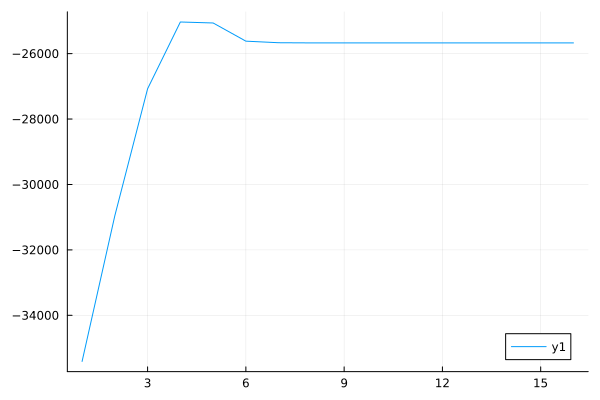

In [8]:
plot(ll[3:end])

In [9]:
println(est_model.B[1].β)
println(est_model.B[2].β)

println(model.B[1].β)
println(model.B[2].β)


println(est_model.B[1].Σ[1])
println(est_model.B[2].Σ[1])

[-100.16529418592583; -99.78208319008141;;]
[99.77928664177995; 100.01796213003568;;]
[100; 100;;]
[-100; -100;;]
4.6499901789329945
80.97933963184009
